1. Apache Spark

Как я понимаю его после нескольких часов статей и видео:
Ультимативный инструмент для инженера для работы с графовыми алгоритмами, машинным обучением, обработки и анализа данных.
Это движок и набор библиотек, основное приемущество это структура набора данных, которая делится на части в нодах  кластеров, что значительно упрощает и ускоряет работу с данными, особенно с большими, тк при стандартном использовании языков программирования мы ограничены оперативной памятью компьютера.
Поддерживает множество языков для работы.
Разные источники описыват разные приемущества, кто-то полностью работает на спарк, кто-то рекомендует использовать его частично для различных операций. Но это предстоит проверить дальше лично.

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize' : (16,6)}, style="whitegrid")

In [2]:
table = pd.read_parquet('/Users/dmyakovlev/Desktop/fcst.parquet',)

In [3]:
table.head()

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
0,0,1,743.0,5316.803341,5978.720782,4267.971145,4283.282927
1,1,1,2851.0,2984.880237,2591.821366,2650.744227,2505.751384
2,2,1,2183.0,2580.991286,3030.257809,2762.233600,2722.675689
3,3,1,1867.0,816.092797,159.134282,1162.324517,908.373377
4,4,1,3442.0,3898.294959,3280.919560,3636.127401,3752.789970


Изучим данные

In [4]:
table.shape

(930, 7)

In [5]:
table.dtypes

id               int64
time_period      int64
sales          float64
fcst1          float64
fcst2          float64
fcst3          float64
fcst4          float64
dtype: object

In [6]:
table.describe()

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
count,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,58.306452,4.534409,5835.806452,4576.589131,5163.660530,4641.841656,4013.288654
std,33.877123,2.289913,11802.887836,9333.606705,8633.606995,9882.923464,7303.040683
min,0.000000,1.000000,1.000000,47.578076,-598.811065,-180.897304,-33.547054
25%,29.000000,3.000000,758.000000,608.830656,1661.954150,777.115580,412.589021
50%,58.500000,5.000000,2053.500000,1807.898673,2782.451917,1844.123203,1426.920042
75%,87.750000,7.000000,5466.750000,4883.102332,4960.071922,4387.844722,4279.336002
max,120.000000,8.000000,128950.000000,135445.001194,112443.508856,139351.046333,66383.716284


Пропущенных значений и нулей нет, айдишники и временные метки преобразований не требуют

У трех моделей наблюдаем отрицательные значения, проверим насколько много таких выбросов

In [8]:
table[table.fcst2 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
267,3,3,629.0,1217.393804,-598.811065,1638.073896,1368.579021
322,56,3,256.0,324.814822,-12.078556,222.245280,233.006340
427,3,4,596.0,918.979979,-346.044486,1223.218830,906.262423
522,3,5,392.0,892.902306,-384.462354,1283.148247,1029.801734
654,3,6,463.0,1306.697973,-381.796940,1700.005139,1407.558994
799,3,7,320.0,883.999918,-335.031317,1309.236461,1012.855068
871,3,8,2280.0,883.176212,-368.238770,1323.570857,1090.849136


In [9]:
table[table.fcst3 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
229,70,3,329.0,271.582036,1300.009588,-7.130992,49.920105
318,41,3,457.0,468.783149,2114.621573,-13.766030,42.884493
348,47,4,1.0,63.018438,482.180784,-180.897304,6.795815


In [10]:
table[table.fcst4 < 0]

,id,time_period,sales,fcst1,fcst2,fcst3,fcst4
98,98,1,13301.0,3730.953238,5452.613747,2961.530749,-33.547054
363,52,4,3.0,102.025875,691.090831,109.709187,-5.788873
372,41,4,9.0,230.031687,1430.217227,194.693049,-3.308518
404,63,4,8.0,343.050336,2135.980704,292.470357,-7.679724
421,61,4,2077.0,402.188841,1684.626236,597.121376,-0.049494
605,28,6,2031.0,573.853964,1639.232357,175.931620,-13.174704


Видим, что больше таких значений у второй модели, но в целом, погрешность меньше 1 процента. 

У второй модели почти все минусы связаны с товаром с id 3 ( в 6-и из 8-ми временных периодов модель этот товар посчитала в ноль). У четвертой выбросы чаще связаны с 4-ым периодом. 

Посмотрим, как данные о продажах выглядят на графике

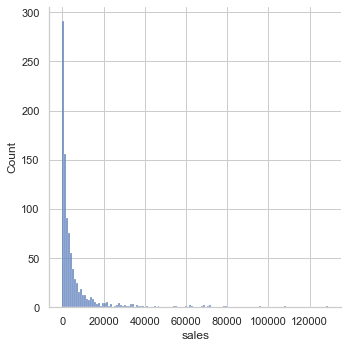

In [12]:
sns.displot(table.sales, kde=False)

Видим, что наибольшее количество приходится на показатели продаж до 1000. Плавно уменьшается до 20000 и после этого значения показатели встречаются редко. Поделим наши данные на три группы по продажам, чтобы проверить насколько хорошо разные прогнозы справляются с разными показателями.

1 - до 1000; 2 - от 1000 до 5000; 3 - более 5000

In [14]:
table1 = table[table.sales < 1000] 

In [15]:
table2 = table.loc[(table.sales > 1000) & (table.sales < 5000), :]

In [16]:
table3 = table[table.sales > 5000]

Так же посмотрим на самые продаваемые товары, чтобы посмотреть, как метрики справляются с бестселлерами

In [17]:
table.groupby('id', as_index=False).agg({'sales' : 'sum'}) \
    .sort_values('sales', ascending=False) \
    .head()

,id,sales
79,79,684320.0
77,77,324014.0
85,85,298491.0
117,117,276159.0
64,64,238596.0


Дополнительно разобьем товары на 5 групп (по 24 в каждой группе) по количеству продаж и проверим прогнозы на каждом из них для более глубокого описания

Так же посмотрим на продажи по периодам

In [18]:
table.groupby('time_period', as_index=False).agg({'sales' : 'sum'}) \
    .sort_values('sales', ascending=False)

,time_period,sales
7,8,1178050.0
2,3,831705.0
5,6,692095.0
3,4,589139.0
1,2,578109.0
0,1,539477.0
4,5,517456.0
6,7,501269.0


Дополнительно проверим модели по самым большому и маленькому по продажам периодам

По результатам все отобранных значений посчитаем MAPE и WAPE  в по общим данным и по отдельно выбранным характеристикам, так же подсчитаем недо и перепрогнозы. На основе полученных данных сделал таблицы.

In [19]:
table_forecasts = pd.read_csv('/Users/dmyakovlev/Desktop/forecasts.csv')

In [20]:
table_forecasts

,name,fcst1,fcst2,fcst3,fcst4
0,under,0.2,0.1,0.2,0.3
1,over,0.2,0.4,0.2,0.2
2,total,0.4,0.5,0.4,0.5


In [27]:
table_MW = pd.read_csv('/Users/dmyakovlev/Desktop/MAPE_WAPE.csv')

In [28]:
table_MW

,table_name,MAPE 1,WAPE 1,MAPE 2,WAPE 2,MAPE 3,WAPE 3,MAPE 4,WAPE 4
0,table,0.50,0.5,0.40,0.60,0.50,0.5,0.45,0.50
1,table1,0.40,0.5,0.10,0.10,0.30,0.5,0.30,0.40
2,table2,0.60,0.6,0.60,0.60,0.60,0.6,0.50,0.50
3,table3,0.60,0.5,0.60,0.60,0.50,0.5,0.50,0.50
4,idtop1,0.15,0.2,0.20,0.35,0.20,0.2,0.10,0.30
5,idtop2,0.60,0.6,0.35,0.60,0.40,0.6,0.45,0.60
6,idtop3,0.75,0.8,0.80,0.90,0.75,0.5,0.70,0.75
7,idtop4,0.15,0.4,0.30,0.35,0.10,0.3,0.75,0.80
8,idtop5,0.40,0.6,0.30,0.50,0.50,0.6,0.10,0.40
9,time period 8,0.30,0.4,0.40,0.40,0.40,0.4,0.30,0.40


Подведем итоги.

По результатам всех тестов на выбранных группах мы имеем следующие данные:

Из данных четерых прогнозов самым оптимальным прогнозом является номер 2. В среднем он показывает самые близкие прогнозы к продажам, лучше всех работает с самыми продаваемыми товарами, так же, что крайне важно, имеет самый низкий показатель недопрогноза, что, особенно в условиях товаров с большим сроком годности, имеет немаловажное значение, тк за счет постоянного наличия на полках товаров, особенно самых продаваемых, мы получаем более лояльную аудиторию, что положительно сказывается на будущих продажах.

После подсчетов стандартного отклонения прогнозов я предлагаю объединение второй модели с первой, объединив сильные стороны первого прогноза лучше предсказывать менее продаваемые товары и второго лучше предсказывать самые продаваемые, после чего у новой модели общие показатели станут выше. Так же это позволит снизить издержки на хранение излишнего количества менее продаваемых товаров на складах.